<a href="https://colab.research.google.com/github/u-tokyo-gps-tanaka-lab/shogilib/blob/main/shogi_position_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1万標本に基づく将棋の状態数推計

※本notebookの実行には、研究報告中の実験に使用したマシン（CPU: AMD Ryzen Threadripper 2990WX, メモリ容量: 128GB）を利用しても、約40分の時間がかかります。実行の際にはご注意ください。


In [2]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 0s (19.5 MB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipaf

## 将棋のドメインロジックの定義・局面表示関数の定義

In [3]:
#!/usr/bin/env python
# coding: utf-8

from collections import defaultdict
from enum import Enum, IntEnum

## Define the game of Shogi

# The board sizes
H = 9
W = 9


# Sente (先手) is white, and Gote (後手) is black.
class Player(Enum):
    WHITE = 0
    BLACK = 1

    def flip(self):
        return Player(1 - self.value)

    def __lt__(self, other):
        return self.value < other.value


WHITE = Player.WHITE
BLACK = Player.BLACK

# The promotion zones for each player
ZONE_Y_AXIS = {WHITE: [True] * 3 + [False] * 6, BLACK: [False] * 6 + [True] * 3}


def player2c(player):
    return ["w", "b"][player.value]


def can_promote_y(player, y):
    return ZONE_Y_AXIS[player][y]


ptype_chars = "..plnsbrgkplnsbrgk"
ptype_kchars = "　　歩香桂銀角飛金玉と杏圭全馬龍"

## pieces
# 5 bit
# bit 4 - player (0: white, 1: black)
# bit 3 - is_promoted
# bit 0-2 - base piece number

# The white pieces are defined as positive integers, and the black pieces as negative.
# If a piece is promoted, its absolute value is increased by 8.


# The positions are ordered according to the following rules:
# - promoteしていない番号が小さい順
# - promoteしていない駒 < promoteしている駒
# - 自分の駒 < 相手の駒
class Piece(IntEnum):
    BLANK = 0
    W_PAWN = 2
    W_LANCE = 3
    W_KNIGHT = 4
    W_SILVER = 5
    W_BISHOP = 6
    W_ROOK = 7
    W_GOLD = 8
    W_KING = 9
    W_PPAWN = 2 | 8
    W_PLANCE = 3 | 8
    W_PKNIGHT = 4 | 8
    W_PSILVER = 5 | 8
    W_PBISHOP = 6 | 8
    W_PROOK = 7 | 8
    B_PAWN = 2 | 16
    B_LANCE = 3 | 16
    B_KNIGHT = 4 | 16
    B_SILVER = 5 | 16
    B_BISHOP = 6 | 16
    B_ROOK = 7 | 16
    B_GOLD = 8 | 16
    B_KING = 9 | 16
    B_PPAWN = 2 | 8 | 16
    B_PLANCE = 3 | 8 | 16
    B_PKNIGHT = 4 | 8 | 16
    B_PSILVER = 5 | 8 | 16
    B_PBISHOP = 6 | 8 | 16
    B_PROOK = 7 | 8 | 16

    def is_promoted(self) -> bool:
        return self.value & 15 >= 10

    def promote(self):
        return Piece(self.value | 8)

    def unpromote(self):
        return Piece(self.value & 0x17)

    def player(self):
        return Player(self.value >> 4)

    def ptype(self):
        return Ptype(self.value & 15)

    def fen(self):
        s = ptype_chars[self.value & 15]
        s = s if self.player() == BLACK else s.upper()
        s = ("+" if self.is_promoted() else "") + s
        return s

    def __lt__(self, other):
        pt0, pt1 = self.ptype(), other.ptype()
        if pt0 != pt1:
            return pt0 < pt1
        return self.player() < other.player()


BLANK = Piece.BLANK
ptype2i = {}


# Piece types are managed separately from the pieces.
class Ptype(IntEnum):
    BLANK = 0
    BASIC_MIN = 2
    PAWN = 2
    LANCE = 3
    KNIGHT = 4
    SILVER = 5
    BISHOP = 6
    ROOK = 7
    GOLD = 8
    KING = 9
    BASIC_MAX = 9
    PPAWN = 2 | 8
    PLANCE = 3 | 8
    PKNIGHT = 4 | 8
    PSILVER = 5 | 8
    PBISHOP = 6 | 8
    PROOK = 7 | 8

    def promote(self):
        return Ptype(self.value | 8)

    def unpromote(self):
        return Ptype(self.value & 7)

    def is_promoted(self) -> bool:
        return self.value >= 10

    def unpromote_if(self):
        if self.is_promoted():
            return self.unpromote()
        return self

    def to_piece(self, player):
        if self != Ptype.BLANK:
            return Piece(self.value + (player.value << 4))
        return Piece(0)

    def can_promote(self):
        return self.value < 8

    def must_promote_y(self, player, y):
        if self == Ptype.PAWN or self == Ptype.LANCE:
            if player == WHITE:
                return y == 0
            else:
                return y == H - 1
        elif self == Ptype.KNIGHT:
            if player == WHITE:
                return y <= 1
            else:
                return y >= H - 2
        return False

    def __lt__(self, other):
        i0, i1 = ptype2i[self.unpromote_if()], ptype2i[other.unpromote_if()]
        if i0 != i1:
            return i0 < i1
        return self.is_promoted() and not other.is_promoted()


KING = Ptype.KING
ROOK = Ptype.ROOK
BISHOP = Ptype.BISHOP
GOLD = Ptype.GOLD
SILVER = Ptype.SILVER
PAWN = Ptype.PAWN
LANCE = Ptype.LANCE
KNIGHT = Ptype.KNIGHT
ptype_order = [KING, GOLD, KNIGHT, LANCE, PAWN, SILVER, ROOK, BISHOP, Ptype.BLANK]
ptype2i = {x: i for i, x in enumerate(ptype_order)}

# How many pieces of each type are on the board?
ptype_counts = {
    PAWN: 18,
    LANCE: 4,
    KNIGHT: 4,
    SILVER: 4,
    BISHOP: 2,
    ROOK: 2,
    GOLD: 4,
    KING: 2,
}


def is_on_board(y, x):
    return 0 <= x < 9 and 0 <= y < 9


# Relative coordinates from (y=0, x=0) of the Sente player
N = (-1, 0)
S = (1, 0)
E = (0, 1)
West = (0, -1)
NW = (-1, -1)
NNW = (-2, -1)
NE = (-1, 1)
NNE = (-2, 1)
SW = (1, -1)
SE = (1, 1)

PTYPE_SHORT_DIRECTIONS: dict[int, list[tuple[int, int]]] = {
    KING: [N, S, E, West, NW, NE, SW, SE],
    ROOK: [],
    BISHOP: [],
    GOLD: [N, S, E, West, NW, NE],
    SILVER: [N, NW, NE, SW, SE],
    LANCE: [],
    KNIGHT: [NNW, NNE],
    PAWN: [N],
    ROOK.promote(): [NE, NW, SW, SE],
    BISHOP.promote(): [E, N, West, S],
}
for ptype in [SILVER, PAWN, KNIGHT, LANCE]:
    PTYPE_SHORT_DIRECTIONS[ptype.promote()] = PTYPE_SHORT_DIRECTIONS[GOLD]

PTYPE_LONG_DIRECTIONS: dict[int, list[tuple[int, int]]] = {
    LANCE: [N],
    ROOK: [N, S, E, West],
    BISHOP: [NE, NW, SW, SE],
}
for ptype in [ROOK, BISHOP]:
    PTYPE_LONG_DIRECTIONS[ptype.promote()] = PTYPE_LONG_DIRECTIONS[ptype]

PIECE_SHORT_DIRECTIONS: dict[int, list[tuple[int, int]]] = {}
PIECE_LONG_DIRECTIONS: dict[int, list[tuple[int, int]]] = {}
for ptype, ds in PTYPE_SHORT_DIRECTIONS.items():
    PIECE_SHORT_DIRECTIONS[ptype.to_piece(WHITE)] = ds
    PIECE_SHORT_DIRECTIONS[ptype.to_piece(BLACK)] = []
    for y, x in ds:
        PIECE_SHORT_DIRECTIONS[ptype.to_piece(BLACK)].append((-y, -x))
    if ptype in PTYPE_LONG_DIRECTIONS:
        lds = PTYPE_LONG_DIRECTIONS[ptype]
    else:
        lds = []
    PIECE_LONG_DIRECTIONS[ptype.to_piece(WHITE)] = lds
    PIECE_LONG_DIRECTIONS[ptype.to_piece(BLACK)] = []
    for y, x in lds:
        PIECE_LONG_DIRECTIONS[ptype.to_piece(BLACK)].append((-y, -x))


# The cordinate of a square is specified in the order of (y, x).
# A drop move is specified as (10, ptype).
def s2sq(s):
    assert len(s) == 2
    if s[1] == "@":
        i = ptype_chars.index(s[0].lower())
        if s[0].islower():
            i = -i
        return (Move.DROP_Y, i)
    assert "a" <= s[0] <= "i"
    x = ord(s[0]) - ord("a")
    assert "1" <= s[1] <= "9"
    y = 9 - int(s[1])
    return (y, x)


def sq2s(sq):
    y, x = sq
    if y == Move.DROP_Y:
        c = ptype_chars[Ptype(x)].upper()
        return f"{c}@"
    return f"{'abcdefghi'[x]}{'987654321'[y]}"


class Move:
    DROP_Y = 10

    def __init__(self, from_sq, to_sq, is_promote):
        self.from_sq = from_sq
        self.to_sq = to_sq
        self.is_promote = is_promote

    def __str__(self):
        return f"Move({self.from_sq, self.to_sq, self.is_promote})"

    def __repr__(self):
        return self.__str__()

    def make_drop_move(ptype, to_sq):
        return Move((Move.DROP_Y, ptype.value), to_sq, False)

    def from_uci(s):
        assert len(s) in [4, 5]
        from_sq, to_sq = s2sq(s[:2]), s2sq(s[2:4])
        is_promote = len(s) == 5 and s[4] == "+"
        return Move(from_sq, to_sq, is_promote)

    def to_uci(self):
        return sq2s(self.from_sq) + sq2s(self.to_sq) + ("+" if self.is_promote else "")

    def is_drop(self):
        return self.from_sq[0] == Move.DROP_Y

    def __hash__(self):
        return hash((self.from_sq, self.to_sq, self.is_promote))

    def __eq__(self, other):
        return (
            self.from_sq == other.from_sq
            and self.to_sq == other.to_sq
            and self.is_promote == other.is_promote
        )


# In Fairy-stockfish, a move is converted to a string by UCI::move.


class Position:
    # Note that in the fen strings any field after the 2nd can be omitted, but we fix it to 4 here.
    def __init__(self, side_to_move, board, hands):
        self.side_to_move, self.board, self.hands = side_to_move, board, hands

    @classmethod
    def from_fen(
        cls, fen="lnsgkgsnl/1r5b1/ppppppppp/9/9/9/PPPPPPPPP/1B5R1/LNSGKGSNL[-] w"
    ):
        fen_parts = fen.split(" ")
        if len(fen_parts) != 2:
            raise Exception(f"fen format error : fen={fen}")
        board = [
            [Piece(0)] * W for _ in range(H)
        ]  # The board is represented as a list of rows.
        sbstart = fen_parts[0].index("[")
        bstr = fen_parts[0][:sbstart]
        for y, l in enumerate(bstr.split("/")):
            x = 0
            lastplus = False
            for c in l:
                if c == "+":
                    lastplus = True
                elif c.isdigit():
                    x += int(c)
                else:
                    pt = Ptype(ptype_chars.index(c.lower()))
                    if lastplus:
                        pt = pt.promote()
                    if c.islower():
                        piece = pt.to_piece(BLACK)
                    else:
                        piece = pt.to_piece(WHITE)
                    board[y][x] = piece
                    x += 1
                    lastplus = False
        handstr = fen_parts[0][(sbstart + 1) : -1]
        hands = [[] for _ in range(2)]
        for c in handstr:
            if c == "-":
                continue
            pt = Ptype(ptype_chars.index(c.lower()))
            if c.islower():
                hands[1].append(pt)
            else:
                hands[0].append(pt)
        for pi in range(2):
            hands[pi].sort()
        side_to_move = Player(0) if fen_parts[1][0] == "w" else Player(1)
        return cls(side_to_move, board, hands)

    def to_tuple(self):
        board = tuple(tuple(l) for l in self.board)
        hands = tuple(tuple(l) for l in self.hands)
        return (self.side_to_move, board, hands)

    def __hash__(self):
        return hash(self.to_tuple())

    def __eq__(self, other):
        return self.to_tuple() == other.to_tuple()

    def __lt__(self, other):  # to heap
        #    return True
        return self.to_tuple() < other.to_tuple()

    # Check that the total number of pieces is correct and both kings are on the board.
    def is_consistent(self):
        piececount = defaultdict(int)
        for y in range(H):
            for x in range(W):
                piececount[self.board[y][x]] += 1
        if (
            piececount[KING.to_piece(WHITE)] != 1
            or piececount[KING.to_piece(BLACK)] != 1
        ):
            # print('type1')
            return False
        for pi in range(2):
            for ptype in self.hands[pi]:
                piececount[ptype.to_piece(Player(pi))] += 1

        basecount = defaultdict(int)
        for piece, v in piececount.items():
            basecount[piece.ptype().unpromote_if()] += v
        # print(f'basecount={basecount}')
        for ptype in Ptype:
            if (
                ptype != Ptype.BLANK
                and not ptype.is_promoted()
                and basecount[ptype] != ptype_counts[ptype]
            ):
                # print(f'type2, ptype={ptype}')
                return False
        return True

    def fen(self):
        b = []
        for y in range(H):
            line = []
            lastx = -1
            for x in range(W):
                piece = self.board[y][x]
                if piece != 0:
                    if x - lastx > 1:
                        line.append(str(x - lastx - 1))
                    line.append(piece.fen())
                    lastx = x
            if lastx < 8:
                line.append(str(9 - lastx - 1))
            b.append("".join(line))
        b = "/".join(b)
        hands = []
        for pi in range(2):
            self.hands[pi].sort()
            for ptype in self.hands[pi]:
                hands.append(ptype.to_piece(Player(pi)).fen())
        return f"{b}[{''.join(hands)}] {player2c(self.side_to_move)}"

    def can_move_on(self, player, y, x):
        p = self.board[y][x]
        return p == BLANK or player != p.player()

    # plm: pseudo legal moves
    # rook, bishop, promoted rook, promoted bishop
    def plm_piece(self, moves, player, ptype, y, x):
        # print(f'piece={ptype.to_piece(player)}, short_directions={PIECE_SHORT_DIRECTIONS[ptype.to_piece(player)]}')
        # print(f'type(ptype)={type(ptype)}')
        # print(f'ptype={ptype}, player={player}, piece={ptype.to_piece(player)}, long_directions={PIECE_LONG_DIRECTIONS}, shor_directions={PIECE_SHORT_DIRECTIONS}, {PIECE_SHORT_DIRECTIONS[ptype.to_piece(player)]}')
        for dy, dx in PIECE_LONG_DIRECTIONS[ptype.to_piece(player)]:
            ny, nx = y + dy, x + dx
            while is_on_board(ny, nx):
                # quiet move
                if self.can_move_on(player, ny, nx):
                    if not ptype.must_promote_y(player, ny):
                        moves.append(Move((y, x), (ny, nx), False))
                    if ptype.can_promote() and (
                        can_promote_y(player, y) or can_promote_y(player, ny)
                    ):
                        moves.append(Move((y, x), (ny, nx), True))
                if self.board[ny][nx] != BLANK:
                    break
                ny += dy
                nx += dx
        for dy, dx in PIECE_SHORT_DIRECTIONS[ptype.to_piece(player)]:
            ny, nx = y + dy, x + dx
            if not is_on_board(ny, nx):
                continue
            if self.can_move_on(player, ny, nx):
                if not ptype.must_promote_y(player, ny):
                    moves.append(Move((y, x), (ny, nx), False))
                if ptype.can_promote() and (
                    can_promote_y(player, y) or can_promote_y(player, ny)
                ):
                    moves.append(Move((y, x), (ny, nx), True))

    def all_drop_moves(self, moves, player):
        all_hand_ptype = set(self.hands[player.value])
        if len(all_hand_ptype) == 0:
            return
        for x in range(W):
            xpawncount = sum(
                self.board[y][x] == PAWN.to_piece(player) for y in range(H)
            )
            for y in range(H):
                if self.board[y][x] != BLANK:
                    continue
                for pt in all_hand_ptype:
                    if not (pt == PAWN and xpawncount == 1) and not pt.must_promote_y(
                        player, y
                    ):
                        moves.append(Move.make_drop_move(pt, (y, x)))

    def plm(self, player):
        moves = []
        for y in range(H):
            for x in range(W):
                piece = self.board[y][x]
                if piece != BLANK and piece.player() == player:
                    self.plm_piece(moves, player, piece.ptype(), y, x)
        self.all_drop_moves(moves, player)
        # print(f'moves={moves}')
        return moves

    def king_pos(self, player):
        kp = KING.to_piece(player)
        for y in range(H):
            for x in range(W):
                if self.board[y][x] == kp:
                    return (y, x)
        return (-1, -1)

    def in_check(self, player):
        kingpos = self.king_pos(player)
        op = player.flip()
        moves = self.plm(op)
        for m in moves:
            if m.to_sq == kingpos:
                return True
        return False

    def apply_move(self, player, move):
        new_board = list(list(l) for l in self.board)
        new_hands = list(list(l) for l in self.hands)
        to_sq = move.to_sq
        to_y, to_x = to_sq
        oldp = self.board[to_y][to_x]
        from_sq = move.from_sq
        if move.is_drop():
            ptype = Ptype(from_sq[1])
            drop_piece = ptype.to_piece(player)
            new_board[to_y][to_x] = drop_piece
            new_hands[player.value].remove(ptype)
        else:
            from_y, from_x = from_sq
            piece = self.board[from_y][from_x]
            if move.is_promote:
                piece = piece.promote()
            new_board[to_y][to_x] = piece
            new_board[from_y][from_x] = BLANK
            if oldp != BLANK:
                new_hands[player.value].append(oldp.ptype().unpromote())
                new_hands[player.value].sort()
        return Position(player.flip(), new_board, new_hands)

    def apply_unmove(self, player, move, oldpiece):
        assert self.side_to_move == player.flip()
        new_board = list(list(l) for l in self.board)
        new_hands = list(list(l) for l in self.hands)
        # print(f'new_hands={new_hands}, oldpiece={oldpiece}')
        to_sq = move.to_sq
        to_y, to_x = to_sq
        piece = self.board[to_y][to_x]
        from_sq = move.from_sq
        if move.is_drop():
            ptype = Ptype(from_sq[1])
            drop_piece = ptype.to_piece(player)
            new_board[to_y][to_x] = BLANK
            new_hands[player.value].append(ptype)
            new_hands[player.value].sort()
        else:
            from_y, from_x = from_sq
            piece = self.board[to_y][to_x]
            if move.is_promote:
                piece = piece.unpromote()
            new_board[to_y][to_x] = oldpiece
            new_board[from_y][from_x] = piece
            if oldpiece != BLANK:
                oldptype = oldpiece.ptype()
                new_hands[player.value].remove(oldptype.unpromote_if())
        pos1 = Position(player, new_board, new_hands)
        assert pos1.is_consistent()
        # if not pos1.is_consistent():
        #    print(f'pos={self.fen()}, player={player}, move={move}, oldpiece={oldpiece}')
        return pos1

    # To determine whether a last move is a pawn drop mate, we need to know whether a player is checkmated.
    # A king is checkmated if and only if both of the following conditions are satisfied:
    # 1. A king is in check
    # 2. The checked player has no legal moves
    def in_checkmate(self):
        player = self.side_to_move
        op = player.flip()
        # print(f'in_check={self.in_check(player)}')
        if not self.in_check(player):
            return False
        # print(f'plm={[m.to_uci() for m in self.plm(player)]}')
        for m in self.plm(player):
            pos1 = self.apply_move(player, m)
            # print(f'm={m}, pos1={pos1}')
            # print(f'm={m.to_uci()}, pos1={pos1.fen()}')
            if not pos1.can_capture_op_king():
                return False
        return True

    def legal_piece_positions(self):
        # 二歩 (Ni-Fu, or 'two pawns')
        for x in range(W):
            if sum(self.board[y][x] == PAWN.to_piece(WHITE) for y in range(H)) > 1:
                return False
            if sum(self.board[y][x] == PAWN.to_piece(BLACK) for y in range(H)) > 1:
                return False
        # 行きどころのない駒 ('pieces with no place to go')
        for x in range(W):
            # print(f'0: x={x}', self.board[0][x], self.board[1][x])
            if (
                self.board[0][x] == PAWN.to_piece(WHITE)
                or self.board[0][x] == LANCE.to_piece(WHITE)
                or self.board[0][x] == KNIGHT.to_piece(WHITE)
            ):
                # print(f'1.1:')
                return False
            if self.board[1][x] == KNIGHT.to_piece(WHITE):
                # print(f'1.2:')
                return False
            # print(f'1: x={x}', self.board[H - 1][x], self.board[H - 2][x])
            if (
                self.board[H - 1][x] == PAWN.to_piece(BLACK)
                or self.board[H - 1][x] == LANCE.to_piece(BLACK)
                or self.board[H - 1][x] == KNIGHT.to_piece(BLACK)
            ):
                # print(f'3:')
                return False
            if self.board[H - 2][x] == KNIGHT.to_piece(BLACK):
                # print(f'4:')
                return False
        return True

    def can_capture_op_king(self):
        return self.in_check(self.side_to_move.flip())

    def illegal(self):
        return not self.legal_piece_positions() or self.can_capture_op_king()

    def __str__(self):
        return f"Position{(self.side_to_move, self.board, self.hands)}"


def king_checkmate_pawn(pos: Position, y, x):
    assert pos.board[y][x].ptype() == PAWN
    player = pos.side_to_move.flip()
    dy, dx = PIECE_SHORT_DIRECTIONS[PAWN.to_piece(player)][0]
    ny, nx = y + dy, x + dx
    # print(f'ny, nx = {(ny, nx)}, player={player}')
    if not is_on_board(nx, ny) or pos.board[ny][nx] != KING.to_piece(player.flip()):
        return False
    return pos.in_checkmate()


def generate_previous_moves(pos: Position):
    player = pos.side_to_move
    opp = player.flip()
    moves = []
    for y in range(H):
        for x in range(W):
            piece = pos.board[y][x]
            if piece == BLANK or piece.player() != opp:
                continue
            ptype = piece.ptype()
            if not ptype.is_promoted() and ptype != KING:
                if ptype != PAWN or not king_checkmate_pawn(pos, y, x):
                    moves.append(Move.make_drop_move(piece.ptype(), (y, x)))
            for dy, dx in PIECE_LONG_DIRECTIONS[piece]:
                ny, nx = y - dy, x - dx
                while is_on_board(ny, nx) and pos.board[ny][nx] == BLANK:
                    moves.append(Move((ny, nx), (y, x), False))
                    if ptype.is_promoted() and (
                        can_promote_y(opp, y) or can_promote_y(opp, ny)
                    ):
                        moves.append(Move((ny, nx), (y, x), True))
                    ny -= dy
                    nx -= dx
            for dy, dx in PIECE_SHORT_DIRECTIONS[piece]:
                ny, nx = y - dy, x - dx
                if not is_on_board(ny, nx) or pos.board[ny][nx] != BLANK:
                    continue
                moves.append(Move((ny, nx), (y, x), False))
            if ptype.is_promoted():
                oldpiece = ptype.unpromote().to_piece(opp)
                for dy, dx in PIECE_LONG_DIRECTIONS[oldpiece]:
                    ny, nx = y - dy, x - dx
                    while is_on_board(ny, nx) and pos.board[ny][nx] == BLANK:
                        if ptype.is_promoted() and (
                            can_promote_y(opp, y) or can_promote_y(opp, ny)
                        ):
                            moves.append(Move((ny, nx), (y, x), True))
                        ny -= dy
                        nx -= dx
                for dy, dx in PIECE_SHORT_DIRECTIONS[oldpiece]:
                    ny, nx = y - dy, x - dx
                    if not is_on_board(ny, nx) or pos.board[ny][nx] != BLANK:
                        continue
                    if can_promote_y(opp, y) or can_promote_y(opp, ny):
                        moves.append(Move((ny, nx), (y, x), True))
    return moves


def generate_previous_positions(pos: Position):
    ret = []
    moves = generate_previous_moves(pos)
    # print(f'moves={moves}')
    player = pos.side_to_move.flip()
    hands = set(pos.hands[player.value] + [Ptype.BLANK])
    for m in moves:
        if m.is_drop():
            pos1 = pos.apply_unmove(player, m, Ptype.BLANK)
            if not pos1.illegal():
                ret.append(pos1)
        else:
            for ptype in hands:
                pos1 = pos.apply_unmove(player, m, ptype.to_piece(player.flip()))
                if not pos1.illegal():
                    ret.append(pos1)
                if ptype != Ptype.BLANK and ptype.can_promote():
                    pos1 = pos.apply_unmove(
                        player, m, ptype.promote().to_piece(player.flip())
                    )
                    if not pos1.illegal():
                        ret.append(pos1)

    return ret

In [4]:
from collections import Counter

from PIL import Image, ImageDraw, ImageFont

IPAfont_path = "/Users/ktanaka/Library/Fonts/ipag.ttf"
# ryzen0
# IPAfont_path = '/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf'
# thinkpad
# IPAfont_path = '/usr/share/fonts/OTF/ipag.ttf'


def kimage(kchar, grid=40):
    im = Image.new("RGB", (grid, grid))
    draw = ImageDraw.Draw(im)
    draw.rectangle([(0, 0), (grid, grid)], fill=(255, 255, 255))
    fnt = ImageFont.truetype(IPAfont_path, grid)
    draw.text((0, 0), kchar, font=fnt, fill=(0, 0, 0))
    return im


piece2img = {}
for i, kchar in enumerate(ptype_kchars):
    if kchar == "　":
        continue
    isize = 30
    piece2img[Ptype(i).to_piece(WHITE)] = kimage(kchar, isize)
    img = piece2img[i].crop((0, 0, isize, isize))
    piece2img[Ptype(i).to_piece(BLACK)] = img.rotate(180)

piece2img2 = {}
for piece, img in piece2img.items():
    piece2img2[piece] = img.resize((img.width // 2, img.height // 2))


def position_image(pos):
    grid = 40
    offset_y = 40
    offset_x = 55
    W, H = 9, 9
    image_size = (grid * W + 150, grid * H + 60)
    im = Image.new("RGB", image_size)
    draw = ImageDraw.Draw(im)
    draw.rectangle([(0, 0), image_size], fill=(255, 255, 255))
    fnt = ImageFont.truetype(IPAfont_path, 25)
    smallfnt = ImageFont.truetype(IPAfont_path, 15)
    bigfnt = ImageFont.truetype(IPAfont_path, 30)

    # draw the board
    for y in range(H + 1):
        draw.line(
            [
                (offset_x, offset_y + y * grid),
                (offset_x + W * grid, offset_y + y * grid),
            ],
            fill=(0, 0, 0),
            width=3,
        )
    for x in range(W + 1):
        draw.line(
            [
                (offset_x + x * grid, offset_y),
                (offset_x + x * grid, offset_y + H * grid),
            ],
            fill=(0, 0, 0),
            width=3,
        )
    kanji_numbers = ["一", "二", "三", "四", "五", "六", "七", "八", "九"]
    for x in range(W):
        label = str(W - x)
        x_coord = offset_x + (x + 0.4) * grid
        y_coord = offset_y - 0.75 * grid
        draw.text((x_coord, y_coord), label, font=fnt, fill=(0, 0, 0))
    for y in range(H):
        label = kanji_numbers[y]
        x_coord = offset_x + (W + 0.15) * grid
        y_coord = offset_y + (y + 0.2) * grid
        draw.text((x_coord, y_coord), label, font=fnt, fill=(0, 0, 0))
    for y in range(H):
        for x in range(W):
            piece = pos.board[y][x]
            if piece == 0:
                continue
            pimage = piece2img[piece]
            cx, cy = (
                offset_x + grid * (x * 2 + 1) // 2 - pimage.width // 2,
                offset_y + grid * (y * 2 + 1) // 2 - pimage.height // 2,
            )
            im.paste(pimage, (cx, cy))

    # draw the turn marker
    turnx = int(grid * (W + 1.2) + offset_x)
    turny = int(offset_y)
    if pos.side_to_move == WHITE:
        # SENTE (below the board)
        draw.text((turnx, turny), "☗\n先\n手\n番", font=fnt, fill=(0, 0, 0))
    else:
        # GOTE (above the board)
        draw.text((turnx, turny), "☖\n後\n手\n番", font=fnt, fill=(0, 0, 0))

    # draw pieces in the hands
    for pl in range(2):
        hands = pos.hands[pl]
        counts = Counter(hands)
        kvs = list(counts.items())
        for i, (k, v) in enumerate(kvs):
            piece = k.to_piece(WHITE)
            pimage = piece2img2[piece]
            if pl == 0:
                cx, cy = (
                    int(grid * W + offset_x + 1.1 * grid - 6),
                    int(grid * (H - 1 - 0.5 * (i + 1)) + offset_y),
                )
            else:
                cx, cy = (
                    int(offset_x - 1.1 * grid),
                    int(grid * (0.1 + 0.5 * i) + offset_y),
                )
            im.paste(pimage, (cx, cy))
            draw.text((cx + 20, cy), "x" + str(v), font=smallfnt, fill=(0, 0, 0))
    return im


def showstate(state, filename=None):
    img = position_image(state)
    if filename:
        img.save(filename)
    return img


def show_images_hv(images, w, filename=None, showarrow=True):
    width = images[0].width
    height = images[0].height
    for im in images:
        assert im.width == width and im.height == height
    allwidth = width * w
    n = len(images)
    h = (n + w - 1) // w
    ans = Image.new("RGB", (w * width, h * height))
    draw = ImageDraw.Draw(ans)
    draw.rectangle([(0, 0), (w * width, h * height)], fill=(255, 255, 255))
    fnt = ImageFont.truetype(IPAfont_path, 25)
    x, y = 0, 0
    for i, im in enumerate(images):
        ans.paste(im, (x, y))
        if showarrow and i != n - 1:
            draw = ImageDraw.Draw(ans)
            draw.text(
                (x + width * 0.9, y + height * 0.4), ">", font=fnt, fill=(0, 0, 0)
            )
        x += width
        if x >= w * width:
            x = 0
            y += height
    if filename:
        ans.save(filename)
    return ans

## 擬合法局面生成用テーブルの事前計算

※この計算には、無料版Google Colabで数分間かかります。

In [5]:
from math import comb
import json

# ptype_order = [KING, GOLD, KNIGHT, LANCE, PAWN, SILVER, ROOK, BISHOP, Ptype.BLANK]


# returns (handcounts, boardcounts).
# The 'handcounts' and 'boardcounts' are pairs of (piece type, piece count)
def make_count_sub(i):
    if i >= len(ptype_order) or ptype_order[i] == Ptype.BLANK:
        return [([], [])]
    pt = Ptype(ptype_order[i])
    l2 = make_count_sub(i + 1)
    if pt == KING:
        return l2
    l1 = []
    rest = ptype_counts[pt]
    for bc in range(rest + 1):
        hc = rest - bc
        l1add = [[], []]
        if hc > 0:
            l1add[0].append((pt, hc))
        if bc > 0:
            l1add[1].append((pt, bc))
        l1.append(l1add)
    ans = []
    for hc1, bc1 in l1:
        for hc2, bc2 in l2:
            ans.append((hc1 + hc2, bc1 + bc2))
    print(f"make_count_sub(i={i}) return len(ans)={len(ans)}")
    return ans


countall = make_count_sub(0)
countall.sort()
KPOS_COUNT = H * (W // 2) * (H * W - 1) + H * (H * (W + 1) // 2 - 1)


def count_ptype(pt, n_empty, v):
    x = 0
    for pb0 in range(v + 1 if pt.can_promote() else 1):
        v0 = v - pb0
        for pb1 in range(v0 + 1 if pt.can_promote() else 1):
            v1 = v0 - pb1
            for b0 in range(v1 + 1):
                b1 = v1 - b0
                xadd = (
                    comb(n_empty, pb0)
                    * comb(n_empty - pb0, pb1)
                    * comb(n_empty - pb0 - pb1, b0)
                    * comb(n_empty - pb0 - pb1 - b0, b1)
                )
                x += xadd
    return x


def count2N(c):
    hc, bc = c
    hcmult = 1
    hcl = []
    for pt, v in hc:
        hcmult *= v + 1
        hcl.append(v + 1)
    bcl = []
    bcmult = KPOS_COUNT  # KING position
    # print(f'bcmult={bcmult}')
    n_empty = H * W - 2
    for pt, v in bc:
        x = count_ptype(pt, n_empty, v)
        bcmult *= x
        bcl.append(x)
        n_empty -= v
    return hcmult * bcmult, (hcl, bcl)


def main():
    count2num = []
    rank2count = []
    countsum = 0
    for i in range(len(countall)):
        c = countall[i]
        if len(c) != 2:
            print(f"i={i}, c={c}")
        s, l = count2N(c)
        rank2count.append((countsum, c, l))
        countsum += s

    print(countsum)
    with open("count2i.json", "w") as wf:
        json_str = json.dumps({"sum": countsum, "rank2count": rank2count})
        wf.write(json_str)


if __name__ == "__main__":
    main()

make_count_sub(i=7) return len(ans)=3
make_count_sub(i=6) return len(ans)=9
make_count_sub(i=5) return len(ans)=45
make_count_sub(i=4) return len(ans)=855
make_count_sub(i=3) return len(ans)=4275
make_count_sub(i=2) return len(ans)=21375
make_count_sub(i=1) return len(ans)=106875
80880932079767835177773204009328769812438521503800714936366945233084532


## 整数と擬合法局面の相互変換の定義



In [6]:
import sys
import json
from math import comb
from bisect import bisect_left, bisect_right
from functools import reduce
from operator import mul
from collections import defaultdict

COUNT2I_JSON = "count2i.json"


def read_count2i(filename):
    with open(filename) as f:
        return json.load(f)


counts = read_count2i(COUNT2I_JSON)
countsum, rank2count = counts["sum"], counts["rank2count"]
# print(f'countsum={countsum}, len(count2offset)={len(count2offset)}')
hb2oms = {}
for o, hbc, ms in rank2count:
    hbc = (tuple(map(tuple, hbc[0])), tuple(map(tuple, hbc[1])))
    # print(hbc)
    hb2oms[hbc] = (o, ms)


def pos_x(pos):
    return pos // H


def pos_y(pos):
    return pos % H


KPOS_COUNT = H * (W // 2) * (H * W - 1) + H * (H * (W + 1) // 2 - 1)


def kpos_rank2pos(onboards, j, empties):
    """
    WHITE, BLACKのkingのpositionの組のうち，j番目の要素を onboards に追加する．
    Add the j-th element of the set of positions of WHITE and BLACK kings to onboards.

    元の盤面とその左右を反転した盤のうち、小さい方の組み合わせしか生成しない．emptiesのサイズは，H * Wのサイズに限る．
    Generate only the smaller combinations of the original board and its left-right reversed board. The size of empties is limited to H * W.

    空きマスのリスト empties からkingを置いた場合は削除する．
    If a king from the list of empty squares 'empties', remove it.

    座標 pos はx * H + y で計算される非負整数 0 <= pos < H * W
    The cordinate 'pos' is calculated by x * H + y, where 0 <= pos < H * W.

    Args:
        onboards (list[Tuple[Piece, int]]): The target to add the tuple (piece, pos)
        j (int): The j-th element
        empties (list[int]): A list of empty squares of size H * W, which decreases by 2 when executed
    Returns: None
    """
    assert len(empties) == H * W
    assert W % 2 == 1
    assert j < H * (W // 2) * (H * W - 1) + H * (H * W - 1)
    if j < H * (W // 2) * (H * W - 1):
        j0 = j % (H * (W // 2))
        k0 = empties.pop(j0)
        j1 = j // (H * (W // 2))
        k1 = empties.pop(j1)
    else:
        j -= H * (W // 2) * (H * W - 1)
        j0 = j % H
        k0 = empties.pop(H * (W // 2) + j0)
        j1 = j // H
        k1 = empties.pop(j1)
    onboards.append((KING.to_piece(WHITE), k0))
    onboards.append((KING.to_piece(BLACK), k1))


# rest個の空マスから n_pieces を選ぶ時，最小のインデックスを i個にする組み合わせの数
# When selecting 'n_pieces' from 'rest' empty squares, how many combinations are there when the smallest index is 'i'?
comb_table = [[[0] * rest for n_pieces in range(19)] for rest in range(H * W + 1)]
for rest in range(1, H * W + 1):
    for n_pieces in range(1, min(rest, 18) + 1):
        for i in range(rest):
            comb_table[rest][n_pieces][i] = comb(rest - 1 - i, n_pieces - 1)

# rest個の空マスから n_pieces を選ぶ時，最小のインデックスが i個未満の組み合わせの数は?
# When selecting 'n_pieces' from 'rest' empty squares, how many combinations are there when the smallest index is less than 'i'?
comb_table_pre = [
    [[0] * (rest + 1) for n_pieces in range(19)] for rest in range(H * W + 1)
]
for rest in range(1, H * W + 1):
    for n_pieces in range(1, min(rest, 18) + 1):
        for i in range(rest):
            comb_table_pre[rest][n_pieces][i + 1] = (
                comb_table_pre[rest][n_pieces][i] + comb_table[rest][n_pieces][i]
            )


def piece_rank2pos(onboards, piece, j, n_pieces, empties):
    """
    pieceがn_piecesあるとき，小さい順に並んだ座標のリストのうち，j番目の要素を onboards に追加する．
    When there are n_pieces of piece, add the j-th element of the list of coordinates arranged in ascending order to onboards.

    空きマスのリスト empties から削除する．
    Remove it from the list of empty squares 'empties'.

    Args:
        onboards (list[Tuple[Piece, int, int]]): (piece, y, x) を追加する対象
        piece (Piece):
        j (int): j番目の要素
        empties (list[int]): H * W のサイズの空きマスのリスト，実行すると2つ減る
    Returns: None
    """
    rest = len(empties)
    empty_base = 0
    while n_pieces > 0:
        i = bisect_right(comb_table_pre[rest][n_pieces], j) - 1
        j -= comb_table_pre[rest][n_pieces][i]
        rest = rest - 1 - i
        pi = empties.pop(empty_base + i)
        empty_base += i
        onboards.append((piece, pi))
        n_pieces -= 1


def pt2comblist(canp, n_empty, allcount):
    if n_empty < allcount:
        return (0, [])
    rank2comb = []
    comb2rank = {}
    x = 0
    for pb0 in range(allcount + 1 if canp else 1):
        v0 = allcount - pb0
        n_empty_1 = n_empty - pb0
        for pb1 in range(v0 + 1 if canp else 1):
            v1 = v0 - pb1
            n_empty_2 = n_empty_1 - pb1
            for b0 in range(v1 + 1):
                n_empty_3 = n_empty_2 - b0
                b1 = v1 - b0
                xadd = (
                    comb(n_empty, pb0)
                    * comb(n_empty_1, pb1)
                    * comb(n_empty_2, b0)
                    * comb(n_empty_3, b1)
                )
                rank2comb.append((x, (pb0, pb1, b0, b1)))
                comb2rank[(pb0, pb1, b0, b1)] = x
                x += xadd
    return x, rank2comb, comb2rank


canpromote2comb_table = [
    [pt2comblist(True, n_empty, allcount) for allcount in range(18 + 1)]
    for n_empty in range(H * W + 1)
]
nopromote2comb_table = [
    [pt2comblist(False, n_empty, allcount) for allcount in range(18 + 1)]
    for n_empty in range(H * W + 1)
]


def basic_ptype_rank2pos(onboards, pt, empties, n_pieces, j):
    n_empty = len(empties)
    if pt.can_promote():
        combsall = canpromote2comb_table[n_empty][n_pieces]
    else:
        combsall = nopromote2comb_table[n_empty][n_pieces]
    assert j < combsall[0]
    k = bisect_left(combsall[1], (j, (0, 0, 0, 0)))
    if len(combsall[1]) <= k or combsall[1][k][0] > j:
        k -= 1
    j -= combsall[1][k][0]
    combs = combsall[1][k][1]
    for i, x in enumerate(combs):
        if x != 0:
            rest = len(empties)
            v = comb(rest, x)
            cur = j % v
            j //= v
            piece = pt.to_piece(WHITE if i % 2 == 0 else BLACK)
            if i & 2 == 0:
                piece = piece.promote()
            piece_rank2pos(onboards, piece, cur, x, empties)


def rank2l(x):
    j = bisect_left(rank2count, [x, [], []])
    if not (j < len(rank2count) and rank2count[j][0] == x):
        j -= 1
    o, cs, ms = rank2count[j]
    x -= o
    mult = KPOS_COUNT * reduce(mul, ms[0], 1) * reduce(mul, ms[1], 1)
    assert x < mult
    hands = [[], []]
    for i, (pti, v) in enumerate(cs[0]):
        pt = Ptype(pti)
        assert mult % ms[0][i] == 0
        mult //= ms[0][i]
        j = x % ms[0][i]
        x //= ms[0][i]
        for _ in range(j):
            hands[0].append(pt)
        for _ in range(v - j):
            hands[1].append(pt)
    onboards = []
    assert mult % KPOS_COUNT == 0
    mult //= KPOS_COUNT
    j = x % KPOS_COUNT
    x //= KPOS_COUNT
    empties = list(range(H * W))
    kpos_rank2pos(onboards, j, empties)
    for i, (pti, v) in enumerate(cs[1]):
        pt = Ptype(pti)
        assert mult % ms[1][i] == 0
        mult //= ms[1][i]
        j = x % ms[1][i]
        x //= ms[1][i]
        basic_ptype_rank2pos(onboards, pt, empties, v, j)
    return (hands, onboards)


def l2key(l):
    hands, onboard = l
    pts = defaultdict(int)
    for p in range(2):
        for pt in hands[p]:
            pts[pt] += 1
    hc = []
    for pt in ptype_order:
        if pt in pts:
            hc.append((int(pt), pts[pt]))
    p2pos = defaultdict(list)
    for piece, pos in onboard:
        p2pos[piece].append(pos)
    pt2count = defaultdict(int)
    for piece, xs in p2pos.items():
        pt = piece.ptype().unpromote_if()
        pt2count[pt] += len(xs)
    bc = []
    for pt in ptype_order:
        if pt != KING and pt in pt2count:
            bc.append((int(pt), pt2count[pt]))
    return (tuple(hc), tuple(bc))


def piece_pos2rank(pc, empties, posls):
    ans = 0
    rest = len(empties)
    n_pieces = len(posls)
    empty_base = 0
    while n_pieces > 0:
        j = empties.index(posls[-n_pieces])
        v = comb_table_pre[rest - empty_base][n_pieces][j - empty_base]
        ans += v
        empties.pop(j)
        rest -= 1
        # print(f'rest={rest}, empty_base={empty_base}, n_pieces={n_pieces}, j={j}, v={v}, comb_table_pre[rest - empty_base][n_pieces] = {comb_table_pre[rest - empty_base][n_pieces]}')
        # ans += comb_table_pre[rest - empty_base][n_pieces][j - empty_base]

        empty_base = j
        n_pieces -= 1
    return ans


def l2rank(l):
    hands, onboards = l
    hands0 = defaultdict(int)
    for pt in hands[0]:
        hands0[pt] += 1
    pc2pos = defaultdict(list)
    for pc, pos in onboards:
        pc2pos[pc].append(pos)
    hbc = l2key(l)
    # for k in list(hb2oms.keys())[:10]:
    #    print(f'k={k}')
    # print(f'hbc={hbc}, l={l}')
    o, ms = hb2oms[hbc]
    ans = 0
    base = 1
    # hands
    for i in range(len(hbc[0])):
        pt, cnt = hbc[0][i]
        cnt1 = hands0.get(Ptype(pt), 0)
        ans += base * cnt1
        base *= cnt + 1
    # kpos
    empties = list(range(H * W))
    j0 = pc2pos[Piece.W_KING][0]
    empties.pop(j0)
    j1 = empties.index(pc2pos[Piece.B_KING][0])
    empties.pop(j1)
    kpos = 0
    if j0 < H * (W // 2):
        kpos = j0 + j1 * H * (W // 2)
    elif j0 < H * (W // 2 + 1):
        kpos = H * (W // 2) * (H * W - 1) + (j0 % H) + j1 * H
    else:
        print(f"pc2pos={pc2pos}, j0={j0}, j1={j1}")
        raise ValueError(f"invalid king positions ")
    ans += base * kpos
    base *= KPOS_COUNT
    for i in range(len(hbc[1])):
        pt, cnt = hbc[1][i]
        pt = Ptype(pt)
        ptcounts = []
        posls = []
        for j in range(0, 2):  # j == 0 promoted, 1 not promoted
            for p in range(0, 2):  # p == 0 white, 1 black
                if j == 0 and not pt.can_promote():
                    ptcounts.append(0)
                    posls.append([])
                else:
                    pc = pt.to_piece([WHITE, BLACK][p])
                    if j == 0:
                        pc = pc.promote()
                    posl = pc2pos.get(pc, [])
                    ptcounts.append(len(posl))
                    posls.append(posl[:])
        ptcounts = tuple(ptcounts)
        n_empty = len(empties)
        if pt.can_promote():
            x, rank2comb, comb2rank = canpromote2comb_table[n_empty][cnt]
        else:
            x, rank2comb, comb2rank = nopromote2comb_table[n_empty][cnt]
        rank = comb2rank[ptcounts]
        in_rank = 0
        in_rank_base = 1
        for j in range(0, 2):  # j == 0 promoted, 1 not promoted
            for p in range(0, 2):  # p == 0 white, 1 black
                if ptcounts[j * 2 + p] == 0:
                    continue
                n_empty = len(empties)
                pc = pt.to_piece([WHITE, BLACK][p])
                if j == 0:
                    pc = pc.promote()
                v = piece_pos2rank(pc, empties, posls[j * 2 + p])
                in_rank += in_rank_base * v
                in_rank_base *= comb(n_empty, len(posls[j * 2 + p]))
        ans += base * (rank + in_rank)
        base *= x
    return ans + o


def l2pos(l):
    hands, onboards = l
    board = [[BLANK] * W for _ in range(H)]
    for piece, pos in onboards:
        # print(f'piece={piece}, pos={pos}, W={W}, H={H}')
        y, x = pos % H, pos // H
        board[y][x] = piece
    return Position(WHITE, board, hands)


def pos2l(pos):
    hands = pos.hands
    onboards = []
    for y in range(H):
        for x in range(W):
            if pos.board[y][x] != BLANK:
                onboards.append((pos.board[y][x], x * H + y))
    onboards.sort()
    return (hands, onboards)


def rank2pos(x):
    return l2pos(rank2l(x))


def pos2rank(pos):
    l = pos2l(pos)
    # print(f'pos.board={pos.board}, l={l}')
    return l2rank(l)

## 貪欲最良優先探索の定義

In [7]:
from collections import defaultdict
from heapq import heappush, heappop
import argparse


def distance_to_KK(pos):
    ans = 0
    kings = []
    for y in range(H):
        for x in range(W):
            piece = pos.board[y][x]
            if piece != BLANK:
                ptype = piece.ptype()
                if ptype == KING:
                    kings.append((y, x))
                else:
                    ans += 10
                    if ptype.is_promoted():
                        ans += 10
                        pl = piece.player()
                        if pl == WHITE:
                            if y > 2:
                                ans += y - 2
                        else:
                            if y < 6:
                                ans += 6 - y
    assert len(kings) == 2
    # if abs(kings[0][0] - kings[1][0]) + abs(kings[0][1] - kings[1][1]) <= 2:
    #     ans += 10
    return ans


def can_reach_KK(pos):
    prev = {}
    q = [(distance_to_KK(pos), pos)]
    prev[pos] = None
    distance = defaultdict(int)
    distance[pos] = 0
    i = 0
    while len(q) > 0:
        d, pos1 = heappop(q)
        # if i % 1 == 0:
        #    print(f'len(q)={len(q)}, d={d}, pos1={pos1.fen()}')
        i += 1
        # print(f'd={d}, pos1={pos1.fen()}')
        if d == 0:
            ans = [pos1]
            while pos1 != pos:
                pos1 = prev[pos1]
                ans.append(pos1)
            # ans.append(pos)
            # print(f'len(prev)={len(prev)}')
            return (True, [pos.fen() for pos in ans])
        for pos2 in generate_previous_positions(pos1):
            if pos2 not in prev:
                prev[pos2] = pos1
                distance[pos2] = distance[pos1] + 1
                heappush(q, (distance_to_KK(pos2), pos2))
    maxd = max((v, k) for k, v in distance.items())
    return (False, (maxd[0], maxd[1].fen()))

## rankの合法性チェックの定義

In [9]:
def flipHpos(v):
    y, x = v % H, v // H
    x = W - 1 - x
    return x * H + y


def flipH_onboards(xs):
    assert xs[0][0] == KING.to_piece(WHITE)
    assert xs[1][0] == KING.to_piece(BLACK)
    ans = []
    for piece, v in xs:
        ans.append((piece, flipHpos(v)))
    ans.sort()
    return ans


def check_flipH(rank):
    assert rank < countsum
    (hands, onboards) = rank2l(rank)
    onboards1 = onboards[:]
    onboards.sort()
    assert onboards == onboards1
    if flipH_onboards(onboards) < onboards:
        return False
    else:
        return True


def check_prev(rank):
    pos = rank2pos(rank)
    assert pos.side_to_move == WHITE, f"pos={pos.fen()}"
    poslist = generate_previous_positions(pos)
    if len(poslist) != 0:
        return True
    else:
        return False


def check_king(rank):
    pos = rank2pos(rank)
    assert pos.side_to_move == WHITE, f"pos={pos.fen()}"
    if not pos.can_capture_op_king():
        return True
    else:
        return False


def check_piece(rank):
    pos = rank2pos(rank)
    assert pos.side_to_move == WHITE, f"pos={pos.fen()}"
    if pos.legal_piece_positions():
        return True
    else:
        return False


def is_reachable_to_KK(rank):
    pos = rank2pos(rank)
    assert pos.side_to_move == WHITE, f"pos={pos.fen()}"
    tf, ans = can_reach_KK(pos)
    if tf:
        return True
    else:
        return False


"""
if the given rank is reachable, return True.
"""


def is_legal(rank):
    for f in [check_flipH, check_piece, check_king, check_prev, is_reachable_to_KK]:
        status = f(rank)
        # print(f'{f.__name__}({rank}) = {status}')
        if not status:
            return False
    return True

## 標本rankを一様乱数で生成

In [10]:
from random import randrange

RANK_LIMIT = countsum
SAMPLE_all = 10_000

with open("SAMPLE_RANKS.txt", "w") as wf:
    for i in range(SAMPLE_all):
        wf.write(str(randrange(0, RANK_LIMIT)) + "\n")

## rankから局面に変換し、合法性を判定

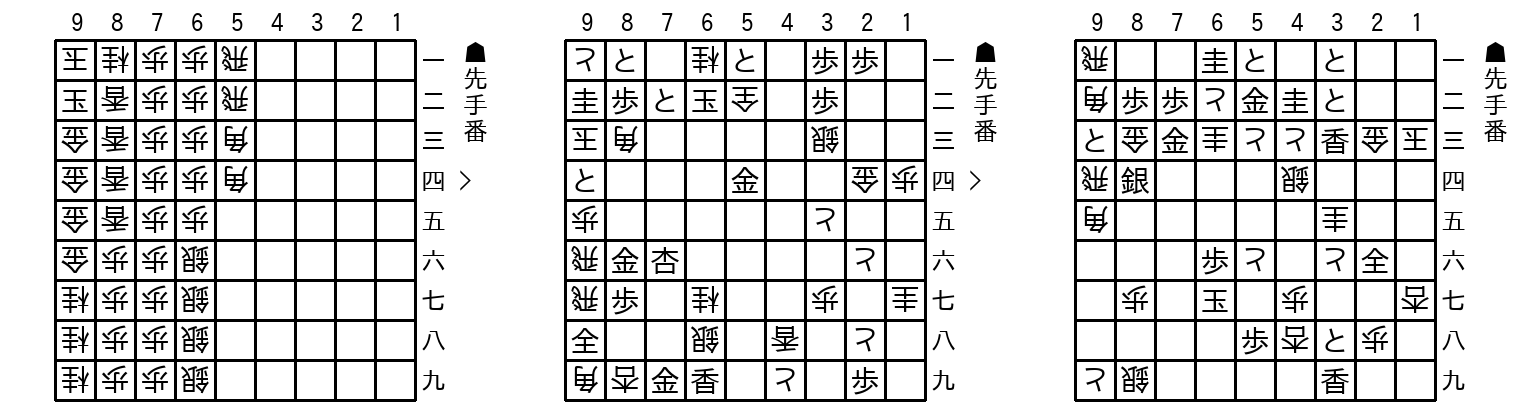

In [ ]:
from IPython.display import display

rank1 = 1
rank2 = 100000000000000000000000000000000000000000000000000000000000000
rank3 = 287722083601566094118215026383000855172253190404886048669594193

assert is_legal(rank1) == False
assert is_legal(rank2) == False
assert is_legal(rank3) == True

pos_examples = list(map(rank2pos, [rank1, rank2, rank3]))
pos_imgs = list(map(showstate, pos_examples))

display(show_images_hv(pos_imgs, 3))

In [ ]:
legal_count = 0
legal_ranks = []

with open("SAMPLE_RANKS.txt") as f:
    for l in f:
        rank = int(l)
        if is_legal(rank):
            legal_count += 1
            legal_ranks.append(rank)

print(f"SAMPLE_ok = {legal_count}")

SAMPLE_ok = 84


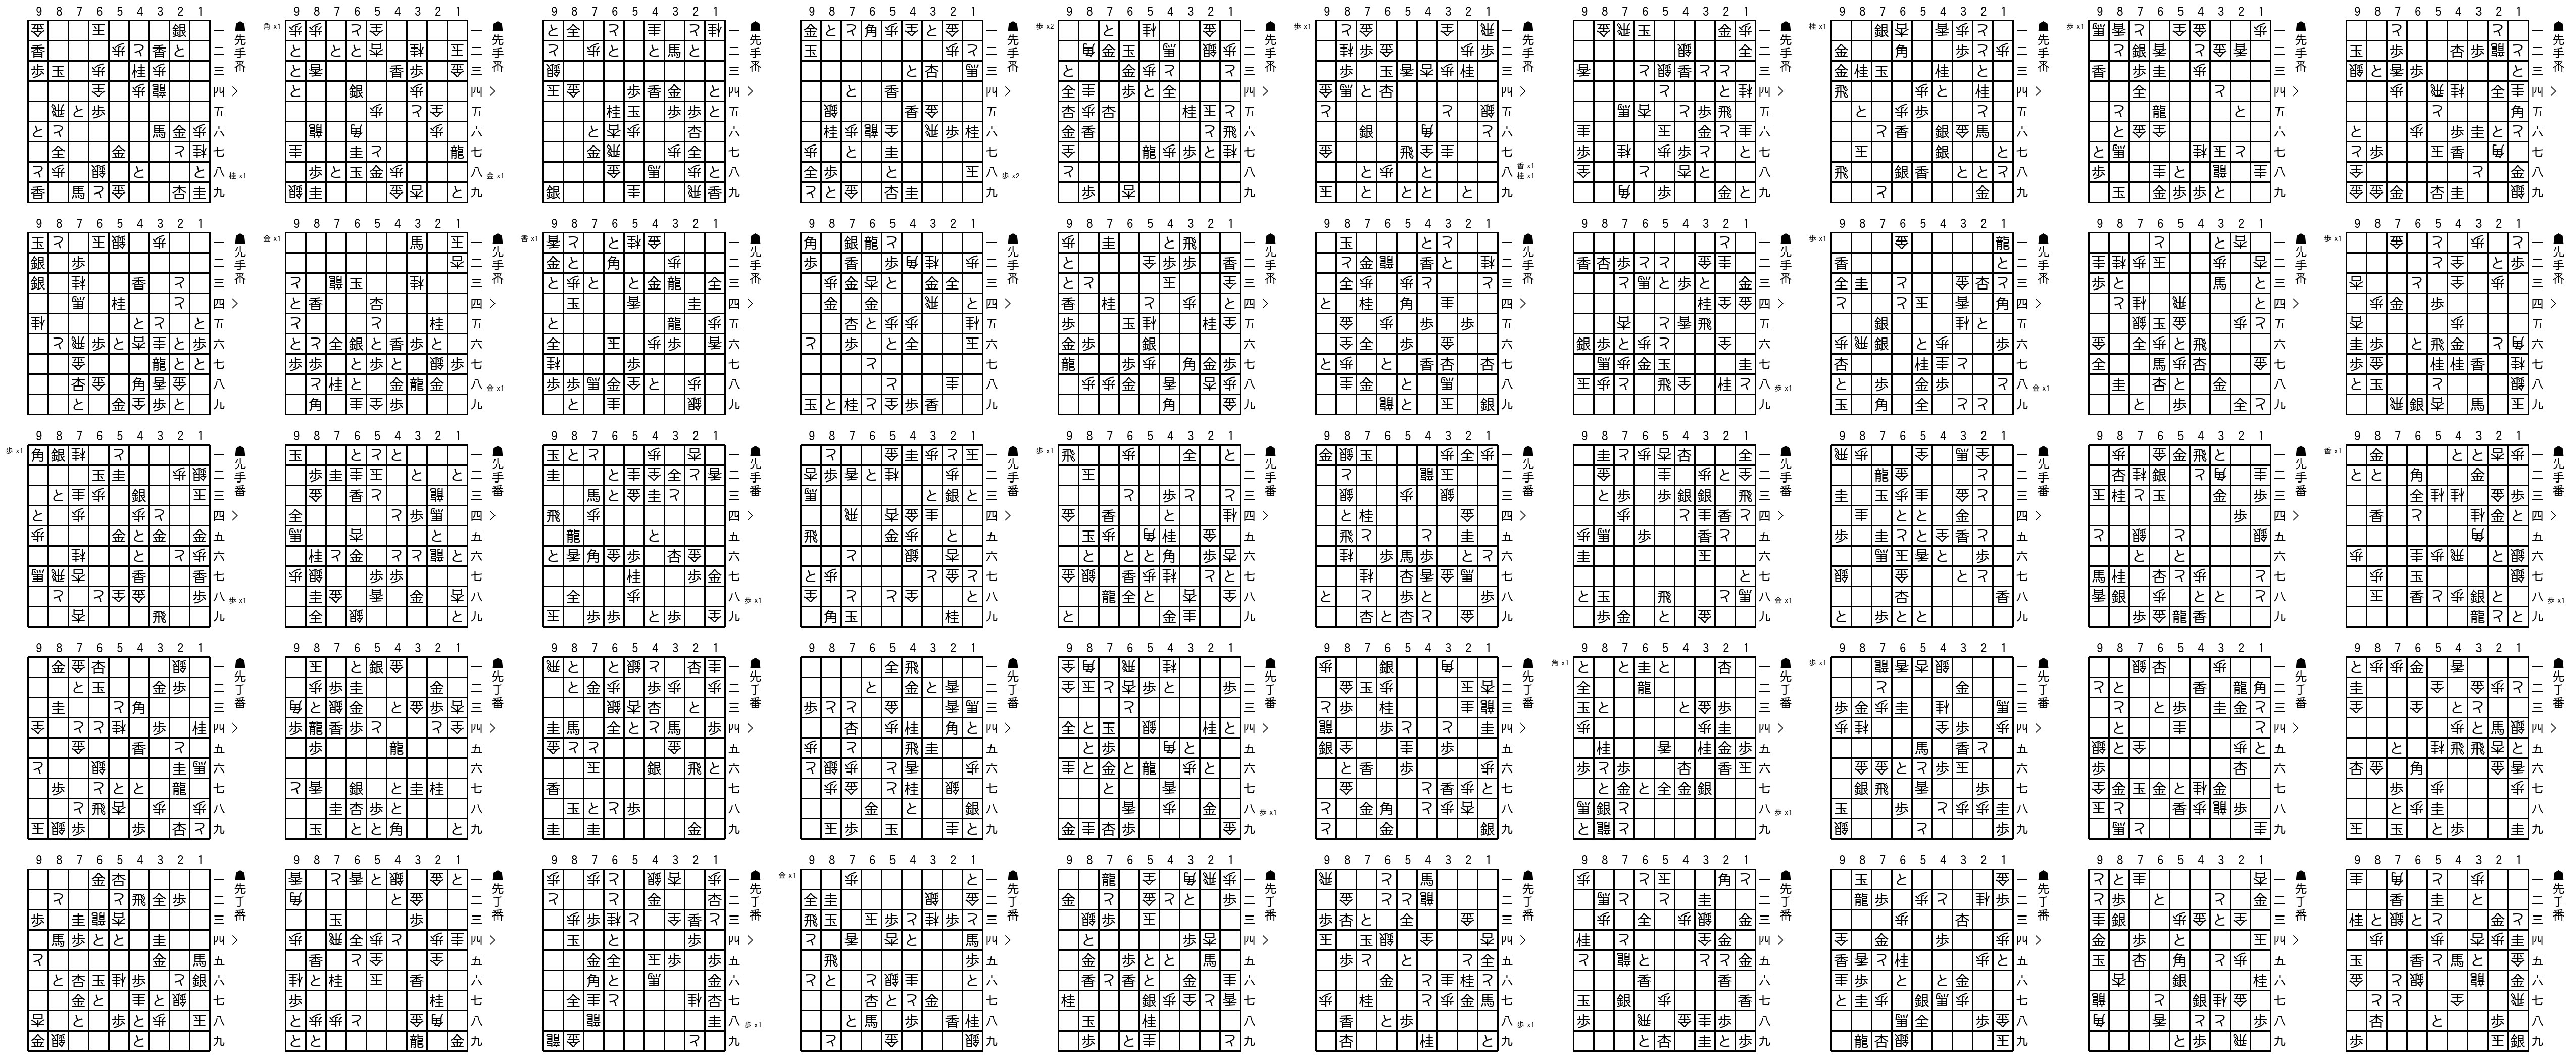

In [ ]:
# 合法だった局面を無作為に50個表示
from random import sample

imgs = []
for r in sample(legal_ranks, 50):
    p = rank2pos(r)
    imgs.append(showstate(p))

display(show_images_hv(imgs, 10))

## 状態数の計算

In [13]:
from math import sqrt

S_all = RANK_LIMIT
SAMPLE_ok = legal_count
SAMPLE_all = 10_000
print(f"|S_all| = {S_all}")
print(f"|SAMPLE_ok| = {SAMPLE_ok}")
print(f"|SAMPLE_all| = {SAMPLE_all}")

print("==========")

p_hat = SAMPLE_ok / SAMPLE_all
sigma_p_hat = sqrt((p_hat * (1 - p_hat)) / SAMPLE_all)
print(f"sigma = {sigma_p_hat}")

p_upper = p_hat + 3 * sigma_p_hat
p_lower = p_hat - 3 * sigma_p_hat
print(f"p_upper = {p_upper}\np_lower = {p_lower}")

print("==========")

expected_S_ok = p_hat * S_all
S_ok_upper = p_upper * S_all
S_ok_lower = p_lower * S_all
print(f"99.73% CI: {S_ok_lower} <= |S_ok| <= {S_ok_upper}")

margin_of_error = S_all * 3 * sigma_p_hat

significand_S_ok = "{:}".format(expected_S_ok).split("e")[0]
exponent_S_ok = int("{:}".format(expected_S_ok).split("e")[1])

# margin_of_errorの指数部をS_okに合わせる
# adjust the exponent of margin_of_error to match that of S_ok
adjusted_significand_MoE = margin_of_error / (10**exponent_S_ok)

print(
    "|S_ok| ~ ({:} ± {:.10f})e{:+d}".format(
        significand_S_ok, adjusted_significand_MoE, exponent_S_ok
    )
)

|S_all| = 80880932079767835177773204009328769812438521503800714936366945233084532
|SAMPLE_ok| = 84
|SAMPLE_all| = 10000
sigma = 0.0009126576576131929
p_upper = 0.01113797297283958
p_lower = 0.005662027027160421
99.73% CI: 4.579500234175718e+68 <= |S_ok| <= 9.00849635522528e+68
|S_ok| ~ (6.793998294700497 ± 2.2144980605)e+68
